## Environment Setting

In [ ]:
!pip install ogb
!pip install torch_geometric
# if neccessary
# import torch, numpy, pandas, urllib3, sklearn, outdated, sys, ogb, os
# os.environ['TORCH'] = torch.__version__
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00


In [ ]:
import torch, numpy, pandas, urllib3, sklearn, outdated, sys, ogb, os
print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)
print("NumPy version:", numpy.__version__)
print("pandas version:", pandas.__version__)
print("urllib3 version:", urllib3.__version__)
print("scikit-learn version:", sklearn.__version__)
print("outdated version:", outdated.__version__)
print("ogb version:", ogb.__version__)

Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
PyTorch version: 2.5.1+cu121
NumPy version: 1.26.4
pandas version: 2.2.2
urllib3 version: 2.2.3
scikit-learn version: 1.5.2
outdated version: 0.2.2
ogb version: 1.3.6


## Load ogbn-mag dataset

In [ ]:
from ogb.nodeproppred import PygNodePropPredDataset

dataset = PygNodePropPredDataset(name = 'ogbn-mag')

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
data = dataset[0]
graph = dataset[0]

Downloaded 0.40 GB: 100%|██████████| 413/413 [00:04<00:00, 98.84it/s] 


Extracting dataset/mag.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 1766.77it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 1109.31it/s]

Saving...



Done!
/usr/local/lib/python3.10/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.pro

In [ ]:
graph

NameError: name 'graph' is not defined

In [ ]:
node_A = torch.range(0,1134649) #Author
node_S = torch.range(0,59965) # field of Study
node_I = torch.range(0,8740) # Institude
node_P = torch.range(0,736389) # Papaer

edge_A2I = graph.edge_index_dict[('author', 'affiliated_with', 'institution')]
edge_A2P = graph.edge_index_dict[('author', 'writes', 'paper')]
edge_P2P = graph.edge_index_dict[('paper', 'cites', 'paper')]
edge_P2S = graph.edge_index_dict[('paper', 'has_topic', 'field_of_study')]

<ipython-input-7-2218eac820b2>:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  node_A = torch.range(0,1134649) #Author
<ipython-input-7-2218eac820b2>:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  node_S = torch.range(0,59965) # field of Study
<ipython-input-7-2218eac820b2>:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  node_I = torch.range(0,8740) # Institude
<ipython-input-7-2218eac820b2>:4: UserWarning: torch.range is deprecated and will be removed in a future release because its behavi

In [ ]:
### Input: target_index: the node index, e.g. 3 or [3,7]; target_edge_group: which group the connected edges are in
### output: edges with start point as nodes in target_inedx
def find_connected_edges(target_index, target_edge_group) -> torch.Tensor:
  if isinstance(target_index, int):
    node_list = [target_index]
  elif isinstance(target_index, list):
    node_list = target_index
  else:
    print('Error: target_index should be int or list')
    return
  edges = target_edge_group

  # --- func ---
  indices =  torch.where(torch.isin(edges[0], torch.tensor(node_list)))[0]
  result = edges[:, indices]
  # --- func end ---

  if result.size()[1] == 0:
    print('Error: no connected edges found for node_list: {}'.format(node_list))
    return

  return result

#func: Exchange the first row and second row
def reverse_edge(edge_group):
  edge_group_INV = torch.zeros_like(edge_group)
  edge_group_INV[0,:] = edge_group[1,:]
  edge_group_INV[1,:] = edge_group[0,:]
  return edge_group_INV

#print(find_connected_edges(2, edge_A2I)) # find institude that author (2) is associated
#print(reverse_edge(find_connected_edges(2, edge_A2I)))

## Visualization: 5 authors' simple version

In [ ]:
# choose 5 author node, visualize their paper, then paper to institude and possibly, paper to paper edges

A = [0, 1, 2, 3, 4]
P = find_connected_edges(A, edge_A2P)[1,:].tolist()
I = find_connected_edges(A, edge_A2I)[1,:].tolist()

# choose paper citation only within the paper wrote by those 5 authors
P2P = find_connected_edges(P, edge_P2P)
P2P = find_connected_edges(P, reverse_edge(P2P))
P2P = reverse_edge(P2P)

A2I = find_connected_edges(A, edge_A2I)
A2P = find_connected_edges(A, edge_A2P)


v_nodes = {
    'A': A,
    'P': P,
    'I': I,
}

v_edges = {
    'A2I': A2I,
    'A2P': A2P,
    'P2P': P2P,
}

node_colors = {
    'A': 'red',
    'P': 'blue',
    'I': 'green',
}

edge_colors = {
    'A2I': 'orange',
    'A2P': 'cyan',
    'P2P': 'magenta',
}

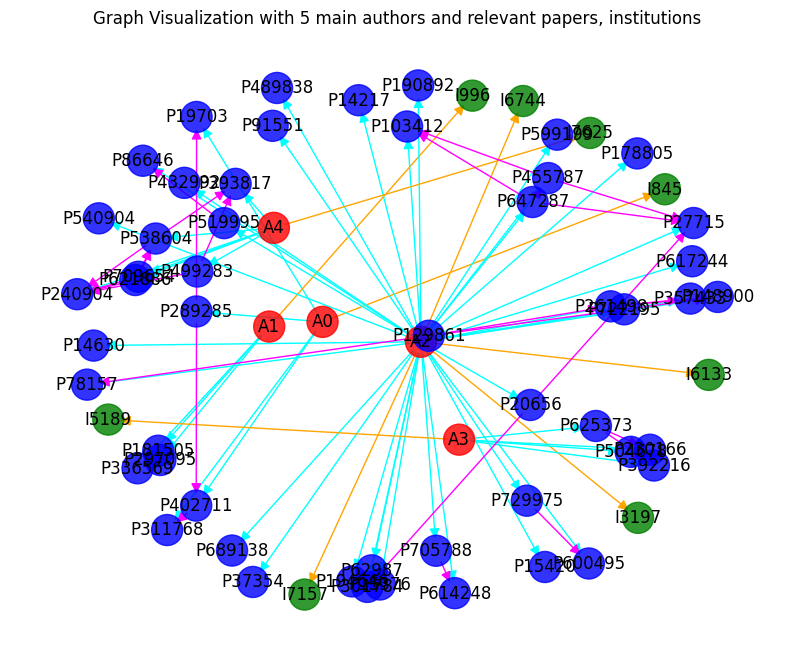

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for node_type, node_tensor in v_nodes.items():
    for node_id in node_tensor:  # this is a list
        node_label = (node_type, node_id)
        G.add_node(node_label, type=node_type)

for edge_type, edge_tensor in v_edges.items():
    for i in range(edge_tensor.shape[1]):  # tensor to list
        edge = edge_tensor[:,i].tolist()
        start_node = ('A', edge[0]) if edge_type.startswith('A2') else \
                     ('P', edge[0])
        end_node = ('P', edge[1]) if edge_type.endswith('2P') else \
                   ('I', edge[1])
        G.add_edge(start_node, end_node, type=edge_type)

node_color_map = [node_colors[G.nodes[node]['type']] for node in G.nodes]
edge_color_map = [edge_colors[G.edges[edge]['type']] for edge in G.edges]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=node_color_map, node_size=500, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color=edge_color_map, arrowstyle='-|>', arrowsize=15)

# draw label
nx.draw_networkx_labels(G, pos, labels={node: f"{node[0]}{node[1]}" for node in G.nodes}, font_size=12, font_color="black")

plt.title("Graph Visualization with 5 main authors and relevant papers, institutions")
plt.axis('off')
plt.show()

## meta2vec

In [ ]:
data.edge_index_dict[('paper', 'wrote by',  'author')] = reverse_edge(data.edge_index_dict[('author', 'writes', 'paper')])
data.edge_index_dict[('paper', 'cited by',  'paper')] = reverse_edge(data.edge_index_dict[('paper', 'cites', 'paper')])
data.edge_index_dict[('institution', 'has',  'author')] = reverse_edge(data.edge_index_dict[('author', 'affiliated_with', 'institution')])
data.edge_index_dict[('field_of_study', 'has',  'paper')] = reverse_edge(data.edge_index_dict[('paper', 'has_topic', 'field_of_study')])
#data.edge_index_dict[('paper', 'published in',  'venue')] = torch.cat((torch.arange(736389).reshape(1,736389), data.y_dict['paper'].T[0].reshape(1,736389)), 0)
#data.edge_index_dict[('venue', 'publishes', 'paper')] = reverse_edge(data.edge_index_dict[('paper', 'published in',  'venue')])

In [ ]:
data

Data(
  num_nodes_dict={
    author=1134649,
    field_of_study=59965,
    institution=8740,
    paper=736389,
  },
  edge_index_dict={
    (author, affiliated_with, institution)=[2, 1043998],
    (author, writes, paper)=[2, 7145660],
    (paper, cites, paper)=[2, 5416271],
    (paper, has_topic, field_of_study)=[2, 7505078],
    (paper, wrote by, author)=[2, 7145660],
    (paper, cited by, paper)=[2, 5416271],
    (institution, has, author)=[2, 1043998],
    (field_of_study, has, paper)=[2, 7505078],
  },
  x_dict={ paper=[736389, 128] },
  node_year={ paper=[736389, 1] },
  edge_reltype={
    (author, affiliated_with, institution)=[1043998, 1],
    (author, writes, paper)=[7145660, 1],
    (paper, cites, paper)=[5416271, 1],
    (paper, has_topic, field_of_study)=[7505078, 1],
  },
  y_dict={ paper=[736389, 1] }
)

In [ ]:
from tqdm import tqdm
import os.path as osp

import torch

import torch_geometric
from torch_geometric.datasets import AMiner
from torch_geometric.nn import MetaPath2Vec

#path = osp.join(osp.dirname(osp.realpath(__file__)), '../../data/AMiner')
#dataset = AMiner(path)
#data = dataset[0]

metapath = [
    ('author', 'writes', 'paper'),
    ('paper', 'cites', 'paper'),
    ('paper', 'wrote by', 'author')
]
metapath2 = [
    ('author', 'writes', 'paper'),
    ('paper', 'has_topic', 'field_of_study'),
    ('field_of_study', 'has', 'paper'),
    ('paper', 'wrote by', 'author')
]
metapath3 = [
    ('institution', 'has', 'author'),
    ('author', 'write', 'paper'),
    ('paper', 'has_topic', 'field_of_study'),
    ('field_of_study', 'has', 'paper'),
    ('paper', 'wrote by', 'author'),
    ('author', 'affiliated_with', 'institution')
]

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch_geometric.is_xpu_available():
    device = torch.device('xpu')
else:
    device = torch.device('cpu')
model = MetaPath2Vec(data.edge_index_dict, embedding_dim=128,
                     metapath=metapath2, walk_length=50, context_size=7,
                     walks_per_node=5, num_negative_samples=5,
                     sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=2)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [ ]:
data

Data(
  num_nodes_dict={
    author=1134649,
    field_of_study=59965,
    institution=8740,
    paper=736389,
  },
  edge_index_dict={
    (author, affiliated_with, institution)=[2, 1043998],
    (author, writes, paper)=[2, 7145660],
    (paper, cites, paper)=[2, 5416271],
    (paper, has_topic, field_of_study)=[2, 7505078],
    (paper, wrote by, author)=[2, 7145660],
    (paper, cited by, paper)=[2, 5416271],
    (institution, has, author)=[2, 1043998],
    (field_of_study, has, paper)=[2, 7505078],
  },
  x_dict={ paper=[736389, 128] },
  node_year={ paper=[736389, 1] },
  edge_reltype={
    (author, affiliated_with, institution)=[1043998, 1],
    (author, writes, paper)=[7145660, 1],
    (paper, cites, paper)=[5416271, 1],
    (paper, has_topic, field_of_study)=[7505078, 1],
  },
  y_dict={ paper=[736389, 1] }
)

In [ ]:
# test_original dataset
# import argparse
# import os.path as osp
# import torch
# #from torch_sparse import transpose
# from torch_geometric.datasets import AMiner
# path = osp.join(osp.dirname('./../data/AMiner'))
# dataset = AMiner(path)
# data = dataset[0]

# from ogb.nodeproppred import PygNodePropPredDataset

# @torch.no_grad()
# def test(train_ratio=0.1):
#     model.eval()
#     #z = model('author', batch=data['author'].y_index.to(device))
#     #y = data['author'].y
#     y = find_connected_edges([0,1,2,3,4,5], data[])

#     perm = torch.randperm(z.size(0))
#     train_perm = perm[:int(z.size(0) * train_ratio)]
#     test_perm = perm[int(z.size(0) * train_ratio):]

#     return model.test(z[train_perm], y[train_perm], z[test_perm], y[test_perm],
#                       max_iter=150)


In [ ]:
def train(epoch, log_steps=100, eval_steps=2000):
    model.train()

    total_loss = 0
    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_steps == 0:
            print(f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                  f'Loss: {total_loss / log_steps:.4f}')
            total_loss = 0

        if (i + 1) % eval_steps == 0:
            save_embedding(model)
            #acc = test()
            #print(f'Epoch: {epoch}, Step: {i + 1:05d}/{len(loader)}, '
                  #f'Acc: {acc:.4f}')
@torch.no_grad()
def save_embedding(model):
    embedding = model('paper').cpu()
    torch.save(embedding, 'embedding.pt')

for epoch in tqdm(range(1, 6)):
    train(epoch)
    save_embedding(model)
    print(f'Epoch: {epoch}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1, Step: 00100/8865, Loss: 9.4034
Epoch: 1, Step: 00200/8865, Loss: 8.2599
Epoch: 1, Step: 00300/8865, Loss: 7.2768
Epoch: 1, Step: 00400/8865, Loss: 6.4900
Epoch: 1, Step: 00500/8865, Loss: 5.8352
Epoch: 1, Step: 00600/8865, Loss: 5.2818
Epoch: 1, Step: 00700/8865, Loss: 4.8105
Epoch: 1, Step: 00800/8865, Loss: 4.4048
Epoch: 1, Step: 00900/8865, Loss: 4.0551
Epoch: 1, Step: 01000/8865, Loss: 3.7624
Epoch: 1, Step: 01100/8865, Loss: 3.5144
Epoch: 1, Step: 01200/8865, Loss: 3.3059
Epoch: 1, Step: 01300/8865, Loss: 3.1282
Epoch: 1, Step: 01400/8865, Loss: 2.9799
Epoch: 1, Step: 01500/8865, Loss: 2.8471
Epoch: 1, Step: 01600/8865, Loss: 2.7295
Epoch: 1, Step: 01700/8865, Loss: 2.6247
Epoch: 1, Step: 01800/8865, Loss: 2.5283
Epoch: 1, Step: 01900/8865, Loss: 2.4404
Epoch: 1, Step: 02000/8865, Loss: 2.3574
Epoch: 1, Step: 02100/8865, Loss: 2.2829
Epoch: 1, Step: 02200/8865, Loss: 2.2105
Epoch: 1, Step: 02300/8865, Loss: 2.1432
Epoch: 1, Step: 02400/8865, Loss: 2.0823
Epoch: 1, Step: 

 20%|██        | 1/5 [13:52<55:28, 832.10s/it]

Epoch: 1
Epoch: 2, Step: 00100/8865, Loss: 1.0385
Epoch: 2, Step: 00200/8865, Loss: 1.0366
Epoch: 2, Step: 00300/8865, Loss: 1.0339
Epoch: 2, Step: 00400/8865, Loss: 1.0314
Epoch: 2, Step: 00500/8865, Loss: 1.0297
Epoch: 2, Step: 00600/8865, Loss: 1.0276
Epoch: 2, Step: 00700/8865, Loss: 1.0248
Epoch: 2, Step: 00800/8865, Loss: 1.0233
Epoch: 2, Step: 00900/8865, Loss: 1.0211
Epoch: 2, Step: 01000/8865, Loss: 1.0196
Epoch: 2, Step: 01100/8865, Loss: 1.0178
Epoch: 2, Step: 01200/8865, Loss: 1.0155
Epoch: 2, Step: 01300/8865, Loss: 1.0143
Epoch: 2, Step: 01400/8865, Loss: 1.0126
Epoch: 2, Step: 01500/8865, Loss: 1.0105
Epoch: 2, Step: 01600/8865, Loss: 1.0093
Epoch: 2, Step: 01700/8865, Loss: 1.0078
Epoch: 2, Step: 01800/8865, Loss: 1.0063
Epoch: 2, Step: 01900/8865, Loss: 1.0044
Epoch: 2, Step: 02000/8865, Loss: 1.0029
Epoch: 2, Step: 02100/8865, Loss: 1.0018
Epoch: 2, Step: 02200/8865, Loss: 1.0005
Epoch: 2, Step: 02300/8865, Loss: 0.9992
Epoch: 2, Step: 02400/8865, Loss: 0.9975
Epoch: 

 40%|████      | 2/5 [28:01<42:05, 841.99s/it]

Epoch: 2
Epoch: 3, Step: 00100/8865, Loss: 0.9486
Epoch: 3, Step: 00200/8865, Loss: 0.9483
Epoch: 3, Step: 00300/8865, Loss: 0.9480
Epoch: 3, Step: 00400/8865, Loss: 0.9480
Epoch: 3, Step: 00500/8865, Loss: 0.9472
Epoch: 3, Step: 00600/8865, Loss: 0.9471
Epoch: 3, Step: 00700/8865, Loss: 0.9467
Epoch: 3, Step: 00800/8865, Loss: 0.9462
Epoch: 3, Step: 00900/8865, Loss: 0.9456
Epoch: 3, Step: 01000/8865, Loss: 0.9455
Epoch: 3, Step: 01100/8865, Loss: 0.9455
Epoch: 3, Step: 01200/8865, Loss: 0.9447
Epoch: 3, Step: 01300/8865, Loss: 0.9446
Epoch: 3, Step: 01400/8865, Loss: 0.9440
Epoch: 3, Step: 01500/8865, Loss: 0.9437
Epoch: 3, Step: 01600/8865, Loss: 0.9436
Epoch: 3, Step: 01700/8865, Loss: 0.9432
Epoch: 3, Step: 01800/8865, Loss: 0.9430
Epoch: 3, Step: 01900/8865, Loss: 0.9427
Epoch: 3, Step: 02000/8865, Loss: 0.9429
Epoch: 3, Step: 02100/8865, Loss: 0.9423
Epoch: 3, Step: 02200/8865, Loss: 0.9424
Epoch: 3, Step: 02300/8865, Loss: 0.9421
Epoch: 3, Step: 02400/8865, Loss: 0.9414
Epoch: 

 60%|██████    | 3/5 [41:46<27:49, 834.61s/it]

Epoch: 3
Epoch: 4, Step: 00100/8865, Loss: 0.9292
Epoch: 4, Step: 00200/8865, Loss: 0.9292
Epoch: 4, Step: 00300/8865, Loss: 0.9289
Epoch: 4, Step: 00400/8865, Loss: 0.9288
Epoch: 4, Step: 00500/8865, Loss: 0.9288
Epoch: 4, Step: 00600/8865, Loss: 0.9284
Epoch: 4, Step: 00700/8865, Loss: 0.9285
Epoch: 4, Step: 00800/8865, Loss: 0.9284
Epoch: 4, Step: 00900/8865, Loss: 0.9284
Epoch: 4, Step: 01000/8865, Loss: 0.9281
Epoch: 4, Step: 01100/8865, Loss: 0.9279
Epoch: 4, Step: 01200/8865, Loss: 0.9280
Epoch: 4, Step: 01300/8865, Loss: 0.9279
Epoch: 4, Step: 01400/8865, Loss: 0.9277
Epoch: 4, Step: 01500/8865, Loss: 0.9275
Epoch: 4, Step: 01600/8865, Loss: 0.9273
Epoch: 4, Step: 01700/8865, Loss: 0.9269
Epoch: 4, Step: 01800/8865, Loss: 0.9272
Epoch: 4, Step: 01900/8865, Loss: 0.9268
Epoch: 4, Step: 02000/8865, Loss: 0.9268
Epoch: 4, Step: 02100/8865, Loss: 0.9267
Epoch: 4, Step: 02200/8865, Loss: 0.9266
Epoch: 4, Step: 02300/8865, Loss: 0.9266
Epoch: 4, Step: 02400/8865, Loss: 0.9264
Epoch: 

 80%|████████  | 4/5 [55:33<13:51, 831.32s/it]

Epoch: 4
Epoch: 5, Step: 00100/8865, Loss: 0.9201
Epoch: 5, Step: 00200/8865, Loss: 0.9201
Epoch: 5, Step: 00300/8865, Loss: 0.9201
Epoch: 5, Step: 00400/8865, Loss: 0.9200
Epoch: 5, Step: 00500/8865, Loss: 0.9202
Epoch: 5, Step: 00600/8865, Loss: 0.9199
Epoch: 5, Step: 00700/8865, Loss: 0.9196
Epoch: 5, Step: 00800/8865, Loss: 0.9199
Epoch: 5, Step: 00900/8865, Loss: 0.9200
Epoch: 5, Step: 01000/8865, Loss: 0.9198
Epoch: 5, Step: 01100/8865, Loss: 0.9195
Epoch: 5, Step: 01200/8865, Loss: 0.9197
Epoch: 5, Step: 01300/8865, Loss: 0.9194
Epoch: 5, Step: 01400/8865, Loss: 0.9199
Epoch: 5, Step: 01500/8865, Loss: 0.9197
Epoch: 5, Step: 01600/8865, Loss: 0.9192
Epoch: 5, Step: 01700/8865, Loss: 0.9192
Epoch: 5, Step: 01800/8865, Loss: 0.9194
Epoch: 5, Step: 01900/8865, Loss: 0.9194
Epoch: 5, Step: 02000/8865, Loss: 0.9194
Epoch: 5, Step: 02100/8865, Loss: 0.9197
Epoch: 5, Step: 02200/8865, Loss: 0.9190
Epoch: 5, Step: 02300/8865, Loss: 0.9193
Epoch: 5, Step: 02400/8865, Loss: 0.9195
Epoch: 

100%|██████████| 5/5 [1:09:35<00:00, 835.09s/it]

Epoch: 5


In [ ]:
import argparse

import torch
import torch.nn.functional as F

from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

#from logger import Logger


class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(MLP, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x):
        for i, lin in enumerate(self.lins[:-1]):
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.log_softmax(x, dim=-1)


def train(model, x, y_true, train_idx, optimizer):
    model.train()

    optimizer.zero_grad()
    out = model(x[train_idx])
    loss = F.nll_loss(out, y_true[train_idx].squeeze(1))
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def test(model, x, y_true, split_idx, evaluator):
    model.eval()

    out = model(x)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']['paper']],
        'y_pred': y_pred[split_idx['train']['paper']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']['paper']],
        'y_pred': y_pred[split_idx['valid']['paper']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']['paper']],
        'y_pred': y_pred[split_idx['test']['paper']],
    })['acc']

    return train_acc, valid_acc, test_acc

In [ ]:
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

dataset = PygNodePropPredDataset(name='ogbn-mag')
split_idx = dataset.get_idx_split()
#data = dataset[0]
print(data)

x = data.x_dict['paper']
if True:
    embedding = torch.load('embedding.pt', map_location='cpu')
    x = torch.cat([x, embedding], dim=-1)
x = x.to(device)

y_true = data.y_dict['paper'].to(device)
train_idx = split_idx['train']['paper'].to(device)

model = MLP(x.size(-1), 256, dataset.num_classes,
            3, 0.0).to(device)

evaluator = Evaluator(name='ogbn-mag')
#logger = Logger(args.runs, args)

train_acc_list = []
valid_acc_list = []
loss_list = []

for run in range(1):
    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(1, 1 + 2000):
        loss = train(model, x, y_true, train_idx, optimizer)
        result = test(model, x, y_true, split_idx, evaluator)


        if epoch % 50 == 0:
            train_acc, valid_acc, test_acc = result
            print(f'Run: {run + 1:02d}, '
                  f'Epoch: {epoch:02d}, '
                  f'Loss: {loss:.4f}, '
                  f'Train: {100 * train_acc:.2f}%, '
                  f'Valid: {100 * valid_acc:.2f}%, '
                  f'Test: {100 * test_acc:.2f}%')
            loss_list.append(loss)
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
import numpy as np
a = np.array([train_acc_list, valid_acc_list, loss_list])
np.save("apfpa.npy", a)

/usr/local/lib/python3.10/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

Data(
  num_nodes_dict={
    author=1134649,
    field_of_study=59965,
    institution=8740,
    paper=736389,
  },
  edge_index_dict={
    (author, affiliated_with, institution)=[2, 1043998],
    (author, writes, paper)=[2, 7145660],
    (paper, cites, paper)=[2, 5416271],
    (paper, has_topic, field_of_study)=[2, 7505078],
    (paper, wrote by, author)=[2, 7145660],
    (paper, cited by, paper)=[2, 5416271],
    (institution, has, author)=[2, 1043998],
    (field_of_study, has, paper)=[2, 7505078],
  },
  x_dict={ paper=[736389, 128] },
  node_year={ paper=[736389, 1] },
  edge_reltype={
    (author, affiliated_with, institution)=[1043998, 1],
    (author, writes, paper)=[7145660, 1],
    (paper, cites, paper)=[5416271, 1],
    (paper, has_topic, field_of_study)=[7505078, 1],
  },
  y_dict={ paper=[736389, 1] }
)


<ipython-input-58-82f7c97bf50d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load('embedding.pt', map_location='cpu')


Run: 01, Epoch: 50, Loss: 2.7315, Train: 30.06%, Valid: 29.51%, Test: 30.20%
Run: 01, Epoch: 100, Loss: 2.4730, Train: 33.73%, Valid: 30.72%, Test: 30.75%
Run: 01, Epoch: 150, Loss: 2.3742, Train: 35.56%, Valid: 31.69%, Test: 31.00%
Run: 01, Epoch: 200, Loss: 2.3069, Train: 36.73%, Valid: 31.10%, Test: 30.51%
Run: 01, Epoch: 250, Loss: 2.2686, Train: 37.44%, Valid: 31.13%, Test: 30.53%
Run: 01, Epoch: 300, Loss: 2.2434, Train: 38.03%, Valid: 30.44%, Test: 29.86%
Run: 01, Epoch: 350, Loss: 2.2204, Train: 38.24%, Valid: 30.86%, Test: 30.59%
Run: 01, Epoch: 400, Loss: 2.1857, Train: 39.07%, Valid: 30.34%, Test: 29.88%
Run: 01, Epoch: 450, Loss: 2.1740, Train: 39.21%, Valid: 30.54%, Test: 29.91%
Run: 01, Epoch: 500, Loss: 2.1555, Train: 39.59%, Valid: 30.60%, Test: 30.04%
Run: 01, Epoch: 550, Loss: 2.1484, Train: 39.52%, Valid: 30.48%, Test: 30.18%
Run: 01, Epoch: 600, Loss: 2.1371, Train: 39.84%, Valid: 30.98%, Test: 30.38%
Run: 01, Epoch: 650, Loss: 2.1338, Train: 39.99%, Valid: 28.86%, 

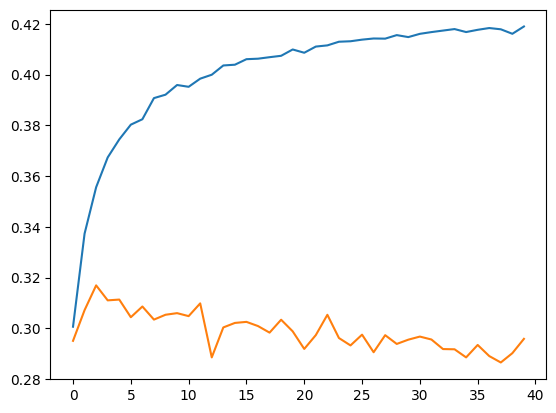

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_acc_list)
plt.plot(valid_acc_list)
#plt.plot(loss_list)

In [ ]:
data.x_dict['paper'].shape

torch.Size([736389, 128])

In [ ]:
data.y_dict['paper']

tensor(348)

In [ ]:
data

Data(
  num_nodes_dict={
    author=1134649,
    field_of_study=59965,
    institution=8740,
    paper=736389,
  },
  edge_index_dict={
    (author, affiliated_with, institution)=[2, 1043998],
    (author, writes, paper)=[2, 7145660],
    (paper, cites, paper)=[2, 5416271],
    (paper, has_topic, field_of_study)=[2, 7505078],
    (paper, wrote by, author)=[2, 7145660],
  },
  x_dict={ paper=[736389, 128] },
  node_year={ paper=[736389, 1] },
  edge_reltype={
    (author, affiliated_with, institution)=[1043998, 1],
    (author, writes, paper)=[7145660, 1],
    (paper, cites, paper)=[5416271, 1],
    (paper, has_topic, field_of_study)=[7505078, 1],
  },
  y_dict={ paper=[736389, 1] }
)

## NARS

In [ ]:
data.edge_index_dict[('paper', 'wrote by',  'author')] = reverse_edge(data.edge_index_dict[('author', 'writes', 'paper')])
data.edge_index_dict[('paper', 'cited by',  'paper')] = reverse_edge(data.edge_index_dict[('paper', 'cites', 'paper')])
data.edge_index_dict[('institution', 'has',  'author')] = reverse_edge(data.edge_index_dict[('author', 'affiliated_with', 'institution')])
data.edge_index_dict[('field_of_study', 'has',  'paper')] = reverse_edge(data.edge_index_dict[('paper', 'has_topic', 'field_of_study')])
data.edge_index_dict[('paper', 'published in',  'venue')] = torch.cat((torch.arange(736389).reshape(1,736389), data.y_dict['paper'].T[0].reshape(1,736389)), 0)
data.edge_index_dict[('venue', 'publishes', 'paper')] = reverse_edge(data.edge_index_dict[('paper', 'published in',  'venue')])

In [ ]:
graph

Data(
  num_nodes_dict={
    author=1134649,
    field_of_study=59965,
    institution=8740,
    paper=736389,
  },
  edge_index_dict={
    (author, affiliated_with, institution)=[2, 1043998],
    (author, writes, paper)=[2, 7145660],
    (paper, cites, paper)=[2, 5416271],
    (paper, has_topic, field_of_study)=[2, 7505078],
  },
  x_dict={ paper=[736389, 128] },
  node_year={ paper=[736389, 1] },
  edge_reltype={
    (author, affiliated_with, institution)=[1043998, 1],
    (author, writes, paper)=[7145660, 1],
    (paper, cites, paper)=[5416271, 1],
    (paper, has_topic, field_of_study)=[7505078, 1],
  },
  y_dict={ paper=[736389, 1] }
)

In [ ]:
label

tensor([1.9397e+06, 3.4900e+02])

In [ ]:
g = data
label = torch.Tensor([1939743, 349])

In [ ]:
g

Data(
  num_nodes_dict={
    author=1134649,
    field_of_study=59965,
    institution=8740,
    paper=736389,
  },
  edge_index_dict={
    (author, affiliated_with, institution)=[2, 1043998],
    (author, writes, paper)=[2, 7145660],
    (paper, cites, paper)=[2, 5416271],
    (paper, has_topic, field_of_study)=[2, 7505078],
  },
  x_dict={ paper=[736389, 128] },
  node_year={ paper=[736389, 1] },
  edge_reltype={
    (author, affiliated_with, institution)=[1043998, 1],
    (author, writes, paper)=[7145660, 1],
    (paper, cites, paper)=[5416271, 1],
    (paper, has_topic, field_of_study)=[7505078, 1],
  },
  y_dict={ paper=[736389, 1] }
)

In [ ]:
# Subgraph Sampling
def preprocess_features(g, rel_subsets, args, device):
    num_paper, feat_size = g.nodes["paper"].data["feat"].shape
    new_feats = [torch.zeros(num_paper, len(rel_subsets), feat_size) for _ in range(args.R + 1)]
    print("Start generating features for each sub-metagraph:")
    for subset_id, subset in enumerate(rel_subsets):
        print(subset)
        feats = gen_rel_subset_feature(g, subset, args, device)
        for i in range(args.R + 1):
            feat = feats[i]
            new_feats[i][:feat.shape[0], subset_id, :] = feat
        feats = None
    return new_feats

In [ ]:
# FFN

In [ ]:
# Train

In [ ]:
# Evaluate & Visualization

## Result

In [22]:
a = np.load("NARS_trian_test_val (1).npy")

In [27]:
a

array([[0.59147102, 0.60045015, 0.60397795, 0.61132422, 0.61453911,
        0.61657859, 0.62290512, 0.62660129, 0.63086451, 0.63115518,
        0.63301359, 0.63707509, 0.64039957, 0.64048852, 0.6433762 ,
        0.64053617, 0.64403856, 0.64786339, 0.64719785, 0.64699295,
        0.65341002, 0.65077013, 0.64799999, 0.65153732, 0.65264124,
        0.65305899, 0.65638189, 0.65104651, 0.66166644, 0.65919015,
        0.66054821, 0.66071976, 0.6550397 , 0.66153619, 0.6627783 ,
        0.66532766, 0.6687268 , 0.66320081, 0.6742099 , 0.66380599,
        0.66218266, 0.65665509, 0.66357726, 0.67061221, 0.66237962,
        0.67349671, 0.67128886, 0.67203699, 0.66915249, 0.66782777,
        0.66865056, 0.66993715, 0.67150171, 0.67294872, 0.67740414,
        0.67438144, 0.66990379, 0.67255957, 0.67795054, 0.67475789,
        0.67867008, 0.67235626, 0.67783618, 0.6765067 , 0.67514546,
        0.66851713, 0.67753597, 0.68528887, 0.68103677, 0.68158317,
        0.68333675, 0.68401975, 0.68052849, 0.67

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
x = ['Metapath2vec - apa',
     'Metapath2vec - apvpa',
     'Metapath2vec - iapvpai',
     'NARS']
y1 = [0.4189, 0.4070, 0.3545, 0.6858]
y2 = [0.2959, 0.3192, 0.2886, 0.5214]

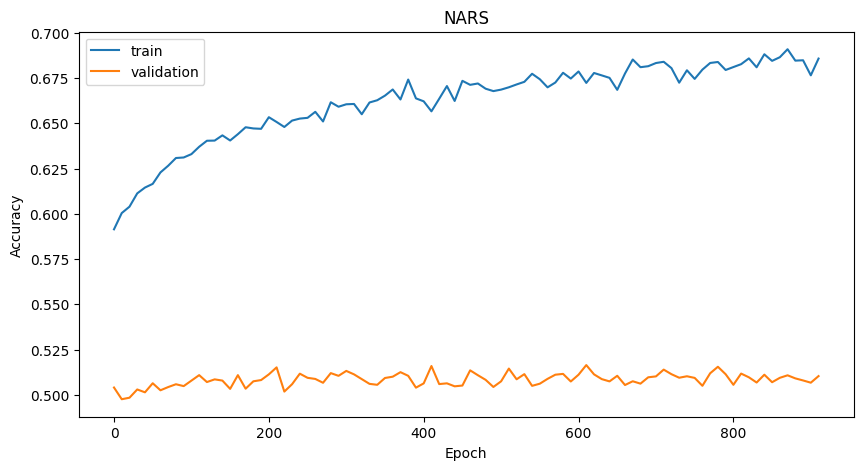

In [48]:
#plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(10, 5))
x = list(range(len(a[0])))
x = [i*10 for i in x]

plt.plot(x, a[0])
plt.plot(x, a[1])
plt.legend(['train', 'validation'])
plt.title("NARS")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [45]:
#plt.style.use('ggplot2')
plt.rcParams.update(plt.rcParamsDefault)

plt.figure(figsize=(10, 4))
plt.barh(x, y1, alpha=1)
plt.barh(x, y2, alpha=1)


plt.legend(['train', 'validation'])
plt.title("Result")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (4,) and arg 3 with shape (92,).